<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/current/AK_MM_Part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will do the following things:


1.   Reproducing Parts III state



*   read names.txt and create a dataset consisting of train, test and validation
*   Create all required layer classes:
    * Linear
    * BatchNorm1d (first with fixed mean and var calculation)
    * Tanh
* Create simple network consisting of:
    * 1 Embedding layer (n_embd = 10)
    * 1 Hidden layer (n_hidden = 200)
    * 1 Output layer
* Train the network with 200000 iterations and batch_size = 32
    * plot the loss naivley and optimized
* Validate the model against val and test
* Sample 20 example from the trained model

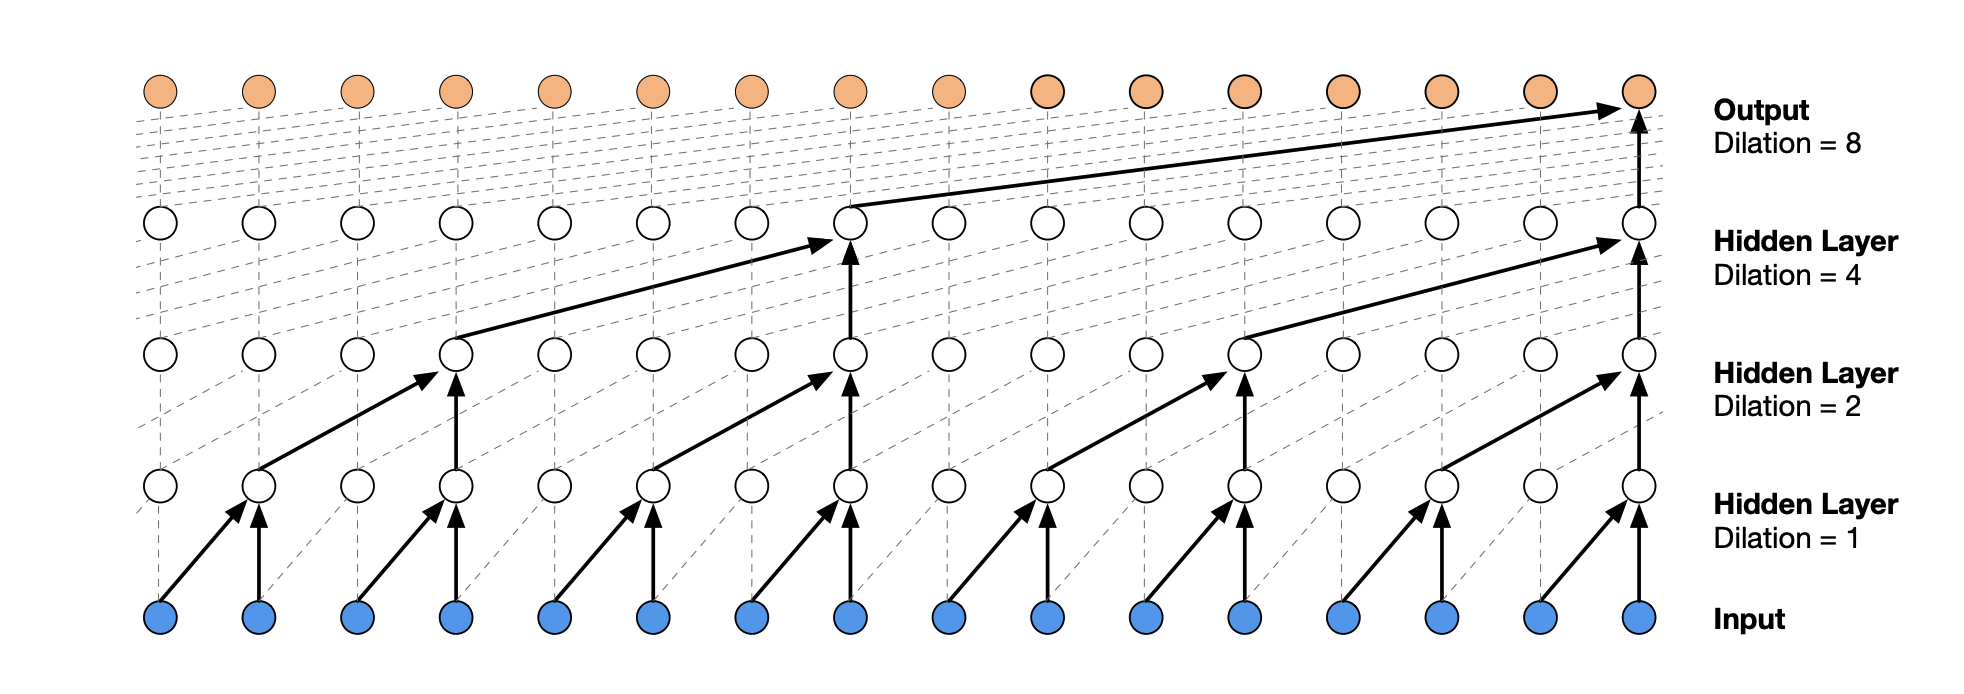


2.   Create the wavenet
* first improvements: improve the code from Part I
    * Introduce Embedding, Flatten and Sequential modules, adjust the training loop and rewrite the existing code
* Wavenet
    * Create a new dataset for the Wavenet approach (block_size=8)
    * make example of a batch of 4 examples of training data and reshape it according to the wavenet paper
    * Introduce FlattenConsecutive and create the WaveNet architecture (n_embd=10, n_hidden=68)
    * create the layer printing function (using the out variables from the modules)
    * adjust BatchNorm1D to work with WaveNet and train the network
    * validate the model against val and test
    * create "diondre" function from Xtr[7:15]





In [16]:
import torch
import torch.nn.functional as F

In [7]:
# Import the library to mount Google Drive
from google.colab import drive
# Mount the Google Drive at /content/drive
drive.mount('/content/drive')
path_to_text_file = "/content/drive/MyDrive/Data/AK/names.txt"

Mounted at /content/drive


In [8]:
with open("/content/drive/MyDrive/Data/AK/names.txt", "r") as file:
  names = []
  for line in file:
    names.append(line.strip())

print(names)

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn', 'abigail', 'emily', 'elizabeth', 'mila', 'ella', 'avery', 'sofia', 'camila', 'aria', 'scarlett', 'victoria', 'madison', 'luna', 'grace', 'chloe', 'penelope', 'layla', 'riley', 'zoey', 'nora', 'lily', 'eleanor', 'hannah', 'lillian', 'addison', 'aubrey', 'ellie', 'stella', 'natalie', 'zoe', 'leah', 'hazel', 'violet', 'aurora', 'savannah', 'audrey', 'brooklyn', 'bella', 'claire', 'skylar', 'lucy', 'paisley', 'everly', 'anna', 'caroline', 'nova', 'genesis', 'emilia', 'kennedy', 'samantha', 'maya', 'willow', 'kinsley', 'naomi', 'aaliyah', 'elena', 'sarah', 'ariana', 'allison', 'gabriella', 'alice', 'madelyn', 'cora', 'ruby', 'eva', 'serenity', 'autumn', 'adeline', 'hailey', 'gianna', 'valentina', 'isla', 'eliana', 'quinn', 'nevaeh', 'ivy', 'sadie', 'piper', 'lydia', 'alexa', 'josephine', 'emery', 'julia', 'delilah', 'arianna', 'vivian', 'kaylee', 'sophie', 'brielle', 'madeline', 'peyton', 'ryle

In [9]:
# Create ITOS and STOI
vocab = ["."] + list(sorted(set("".join([char for words in names for char in words]))))
vocab_size = len(vocab)
itos = {i:c for i,c in enumerate(vocab)}
stoi = {c:i for i,c in enumerate(vocab)}

In [10]:
import random
random.seed(42)
random.shuffle(names)

In [11]:
# Create the dataset (Train, Test, Val)
block_size = 3

def build_dataset(names):
  X = []
  Y = []
  for name in names:
    context = [0] * block_size
    for char in name + ".":
      enc = stoi[char]
      x = context
      y = enc
      X.append(x)
      Y.append(y)
      context = context[1:] + [enc]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

train_end_index = int(0.8 * len(names))
val_end_index = int(0.9 * len(names))
Xtr, Ytr = build_dataset(names[:train_end_index])
Xval, Yval = build_dataset(names[train_end_index:val_end_index])
Xtest, Ytest = build_dataset(names[val_end_index:])

print(Xtr.shape, Ytr.shape)
print(Xval.shape, Yval.shape)
print(Xtest.shape, Ytest.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [12]:
# Understanding the dataset

for i in range(20):
  given = Xtr[i].tolist()
  sequence = "".join(itos[char] for char in given)
  result = Ytr[i].item()
  result_char = itos[result]
  print(f"{sequence} --> {result_char}")

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [13]:
# Defining the layers

# LINEAR LAYER
class Linear:

  def __init__(self, fan_in, fan_out, bias=False):
    self.weight = torch.randn((fan_in, fan_out)) / (fan_in)**0.5
    self.bias = torch.randn(fan_out) if bias else None


  def __call__(self, x):
    x = x @ self.weight
    if self.bias is not None:
      x += self.bias
    self.out = x
    return self.out

  def parameters(self):
    return [self.weight] + ([self.bias] if self.bias is not None else [])

# BATCH NORM (1D)
class BatchNorm1D:

  def __init__(self, num_features, epsilon=1e-05, momentum=0.1, training=True):
    self.epsilon = epsilon
    self.momentum = momentum
    self.running_mean = torch.zeros(num_features)
    self.running_var = torch.ones(num_features)
    self.gamma = torch.ones(num_features)
    self.beta = torch.zeros(num_features)
    self.training = training

  def __call__(self, x):
    if self.training:
      xmean = x.mean(dim=0, keepdim=True)
      xvar =  x.mean(dim=0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    x = (x - xmean) / (xvar + self.epsilon)**0.5 * self.gamma + self.beta
    self.out = x

    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + (self.momentum * xmean)
        self.running_var = (1 - self.momentum) * self.running_var + (self.momentum * xvar)

    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

# TANH ACTIVATION
class Tanh:

  def __init__(self):
    pass

  def __call__(self, x):
    x = torch.tanh(x)
    self.out = x

    return self.out

  def parameters(self):
    return []

In [17]:
# Create a network (first, simple approach)
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
layers = [Linear(30, 200), Tanh(), BatchNorm1D(n_hidden),
          Linear(200, 27)]

parameter_count = 0
parameters = []
for layer in layers:
  for parameter in layer.parameters():
    parameter_count += parameter.nelement()
    parameter.require_grad = True
    parameters.append(parameter)

print(parameter_count)

11800


In [15]:
# Training Loop (first, simple approach)
n_epoch = 200000
learning_rate = 1e-03
batch_size = 32

for i in range(n_epoch):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  embd = C[Xb]
  x = embd.view(batch_size, block_size * n_embd)
  for layer in layers:
    x = layer(x)

  loss = F.cross_entropy(x, Yb)
  loss.backward()

  # step
  for parameter in parameters:
    parameter.grad = True




AttributeError: module 'torch.functional' has no attribute 'cross_entropy'

In [ ]:
torch.randn((2,3)).mean(dim=0).shape

torch.Size([3])

In [ ]:
torch.randint(0, Xtr.shape[0], (batch_size,))

tensor([ 28838, 131675,  42775, 177153,   9387,  78071, 126777, 173942,  74632,
        122652,  93648,  98065, 180911,  36785,  54310,  97965,  49773, 145527,
        109190,  50634, 105376,    460, 103578, 120287, 142823, 133689,  67867,
        162853, 128625,  74225, 143457,  42336])

In [ ]:
C[Xb].shape

torch.Size([32, 3, 10])

In [ ]:
l = Linear(30, 200)
emb = C[Xb]
x = emb.view(32, -1)
for layer in layers:
  x = layer(x)

loss = F.cross_entropy()